In [1593]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
df = pd.read_csv("yyyyyyyy.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'yyyyyyyy.csv'

In [1565]:
# információk a táblázatról

lines = len(df)
print("Ennyi sor van a táblázatban:" , lines)
df.sample(3)

print("Típusok: ",df['Típus'].unique())

print("Korosítás értékei: ",df['Korosítás'].unique())



Ennyi sor van a táblázatban: 1112
Típusok:  ['Inverter' 'Villamos anyag' 'Mechanika' 'Napelemek' 'REZSIANYAGOK' nan]
Korosítás értékei:  ['30-60 nap közötti' '60-90 nap közötti' '180-365 nap közötti'
 '90-180 nap közötti' '2évnél idősebb' '1 évnél idősebb'
 '30 napnál fiatalabb' nan]


In [1566]:
# Adattisztítás 
# Ellenőrizzük a 'Mérlegelt átlagár' oszlop NaN értékeit, és eltávolítjuk azokat

nan_count = df['Mérlegelt átlagár'].isna().sum()

print(f"A 'Mérlegelt átlagár' oszlopban lévő NaN értékek száma: {nan_count}")

nan_rows = df[df['Mérlegelt átlagár'].isna()]

df = df.dropna(subset=['Mérlegelt átlagár'])

nan_count_after = df['Mérlegelt átlagár'].isna().sum()
print(f"A 'Mérlegelt átlagár' oszlopban lévő NaN értékek száma az eltávolítás után: {nan_count_after}")

#print("Az eltávolított sorok: " , nan_rows)

# A megfelelő numerikus értékekre módosítás
df['Mérlegelt átlagár'] = df['Mérlegelt átlagár'].str.replace(',', '.')
df['Mérlegelt átlagár'] = pd.to_numeric(df['Mérlegelt átlagár'], errors='coerce')

df['Szabad készlet'] = df['Szabad készlet'].str.replace(',', '.')
df['Szabad készlet'] = pd.to_numeric(df['Szabad készlet'], errors='coerce')

df['Ebből foglalt'] = df['Ebből foglalt'].str.replace(',', '.')
df['Ebből foglalt'] = pd.to_numeric(df['Ebből foglalt'], errors='coerce')


df['Ebből szabad'] = df['Ebből szabad'].str.replace(',', '.')
df['Ebből szabad'] = pd.to_numeric(df['Ebből szabad'], errors='coerce')

df['Teljes készletérték'] = df['Teljes készletérték'].str.replace(',', '.')
df['Teljes készletérték'] = pd.to_numeric(df['Teljes készletérték'], errors='coerce')

df['Összeg / Mennyiség'] = df['Összeg / Mennyiség'].str.replace(',', '.')
df['Összeg / Mennyiség'] = pd.to_numeric(df['Összeg / Mennyiség'], errors='coerce')

# Megtisztítjuk a táblázatot azoktól a soroktól, ahol mennyiség nincs, csak pl.mérlegelt átlagár
df = df[~((df['Szabad készlet'] == 0) & (df['Ebből foglalt'] == 0))]


lines = len(df)
print("Ennyi sor van a táblázatban:" , lines)

A 'Mérlegelt átlagár' oszlopban lévő NaN értékek száma: 7
A 'Mérlegelt átlagár' oszlopban lévő NaN értékek száma az eltávolítás után: 0
Ennyi sor van a táblázatban: 1105


In [1567]:
# hozzáadok a tabihoz egy új oszlopot ,,Foglalt érték" néven
df['Foglalt érték'] = (df['Ebből foglalt'] != 0) * (df['Teljes készletérték'] - df['Ebből szabad'])
df.to_excel('foglalt érték hozzáadva.xlsx')
#df.sample(40)


A teljes készlet érték (foglaltakkal együtt): 903994078.0425
Az Ebből szabad oszlop összeadott értékei: 660344194.8805
A szabad készlet (csak kivonva): 660344194.8805001
A foglalt tételek összesített ára: 243649883.162
A foglalt sorok száma: 165


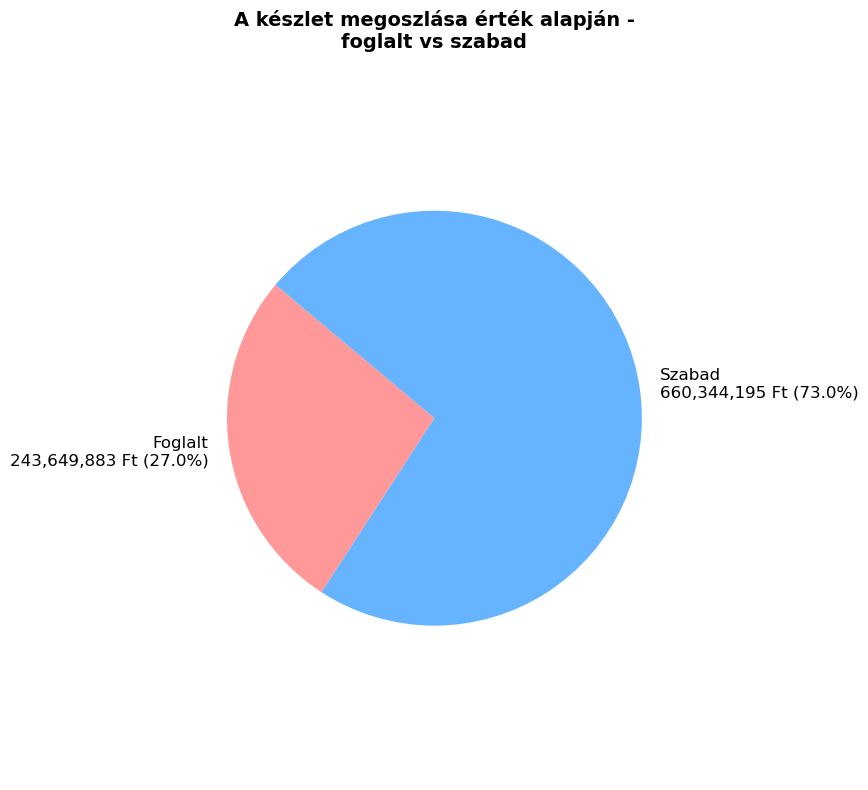

In [1568]:
# Teljes készletérték / Foglalt készletérték / Szabad készletérték

foglalt_osszeg = df['Foglalt érték'].sum()
foglalt_sorok_szama = (df['Foglalt érték'] != 0).sum()

teljes_keszlet_erteke = df['Teljes készletérték'].sum()
print("A teljes készlet érték (foglaltakkal együtt):", teljes_keszlet_erteke)

szabad_keszlet_erteke = df['Ebből szabad'].sum()
print("Az Ebből szabad oszlop összeadott értékei:", szabad_keszlet_erteke)

szabad_keszlet_csak_kivonva = teljes_keszlet_erteke - foglalt_osszeg
print("A szabad készlet (csak kivonva):", szabad_keszlet_csak_kivonva)
print(f"A foglalt tételek összesített ára: {foglalt_osszeg}")
print(f"A foglalt sorok száma: {foglalt_sorok_szama}")

labels = ['Foglalt', 'Szabad']
sizes = [foglalt_osszeg, szabad_keszlet_csak_kivonva]

percentages = [foglalt_osszeg / teljes_keszlet_erteke * 100, szabad_keszlet_csak_kivonva / teljes_keszlet_erteke * 100]

labels_with_values = [
    f"{label}\n{value:,.0f} Ft ({percentage:.1f}%)" 
    for label, value, percentage in zip(labels, sizes, percentages)
]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_values, startangle=140, colors=['#ff9999','#66b3ff'], textprops={'fontsize': 12})
plt.title('A készlet megoszlása érték alapján -\n'
          'foglalt vs szabad', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.axis('equal')
plt.savefig('keszletertekek.png')
plt.show()

data = {
    'Teljes készlet érték (foglaltakkal együtt)': [teljes_keszlet_erteke],
    'Szabad készlet érték': [szabad_keszlet_erteke],
    'Szabad készlet (csak kivonva)': [szabad_keszlet_csak_kivonva],
    'Foglalt tételek összesített ára': [foglalt_osszeg],
    'Foglalt sorok száma': [foglalt_sorok_szama]
}

# Létrehozunk egy DataFrame-et az adataink alapján
df_table = pd.DataFrame(data)

# Exportálás Excel fájlba
df_table.to_excel('keszlet_ertekek.xlsx', index=False)




In [1569]:

# Levonom a foglalt mennyiségeket, árakkal együtt, innentől nem lesznek benne a táblázatban


for index, row in df.iterrows():
    if row['Ebből foglalt'] != 0:
        foglalt = row['Ebből foglalt']        

        df.at[index, 'Összeg / Mennyiség'] -= foglalt    

        df.at[index, 'Ebből foglalt'] = 0
        
        df.at[index, 'Teljes készletérték'] = row['Ebből szabad']

df.to_excel('foglalt értékek levonva.xlsx')


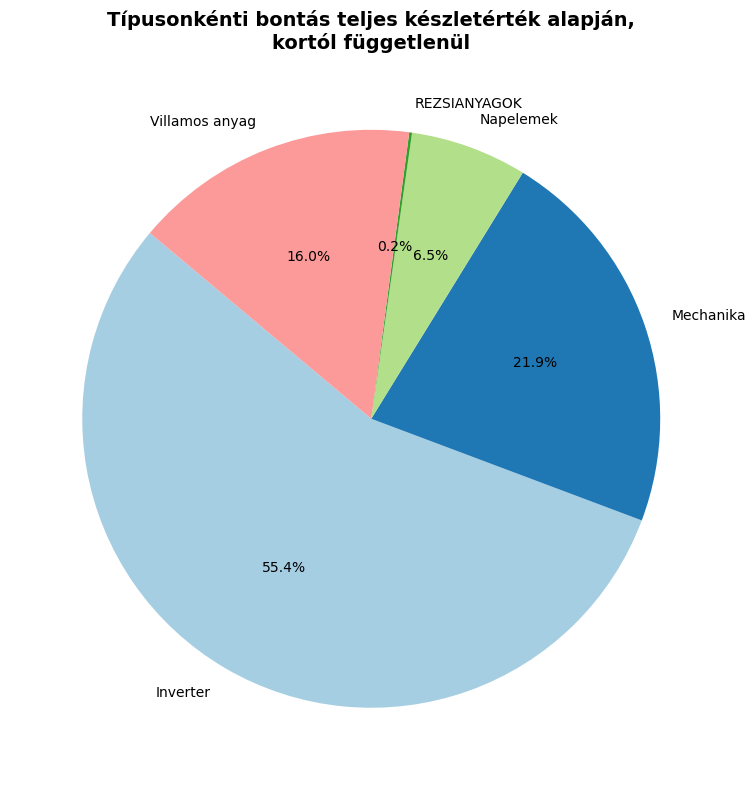

In [1570]:

# Teljes készletérték alapján összesítem típusonként, kortól függetlenül (foglalt már nincs benne)
pivot_ertek = df.pivot_table(values='Teljes készletérték', index='Típus', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    pivot_ertek['Teljes készletérték'],
    labels=pivot_ertek.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Típusonkénti bontás teljes készletérték alapján,\nkortól függetlenül", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('ertek_alapjan_tipusonkent_kortol_fuggetlenul.png')
plt.show()

pivot_ertek.to_excel('ertek_alapjan_tipusonkent_kortol_fuggetlenul.xlsx')


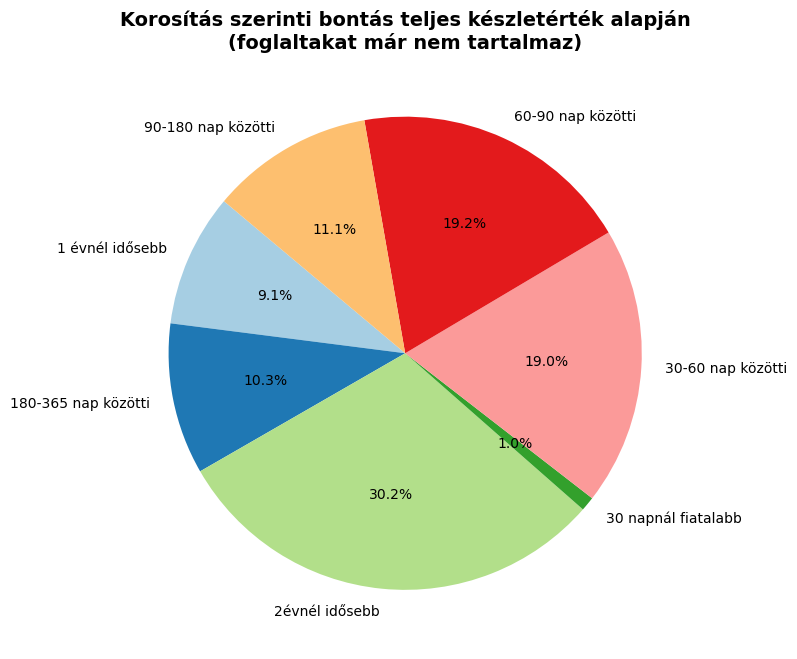

In [1571]:

# Teljes készletérték alapján összesítem korosításonként (foglalt már nincs benne)
pivot_ertek = df.pivot_table(values='Teljes készletérték', index='Korosítás', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    pivot_ertek['Teljes készletérték'],
    labels=pivot_ertek.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Korosítás szerinti bontás teljes készletérték alapján\n(foglaltakat már nem tartalmaz)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('ertek_alapjan_korositasonkent.png')
plt.show()


pivot_ertek.to_excel('ertek_alapjan_korositasonkent.xlsx')

In [1572]:
# típusonként létrehozok külön-külön táblázatokat
inverterek = df[df['Típus'] == 'Inverter']
villamos_anyag = df[df['Típus'] == 'Villamos anyag']
mechanika = df[df['Típus'] == 'Mechanika'] #ebben sok a mínusz, nem kaptam választ, hogy az mit jelent
napelemek = df[df['Típus'] == 'Napelemek']
rezsi_anyagok = df[df['Típus'] == 'REZSIANYAGOK']

inverterek.to_excel('inverterek.xlsx')
villamos_anyag.to_excel('villamos_anyagok.xlsx')
mechanika.to_excel('mechanika.xlsx')
napelemek.to_excel('napelemek.xlsx')
rezsi_anyagok.to_excel('rezsi_anyagok.xlsx')



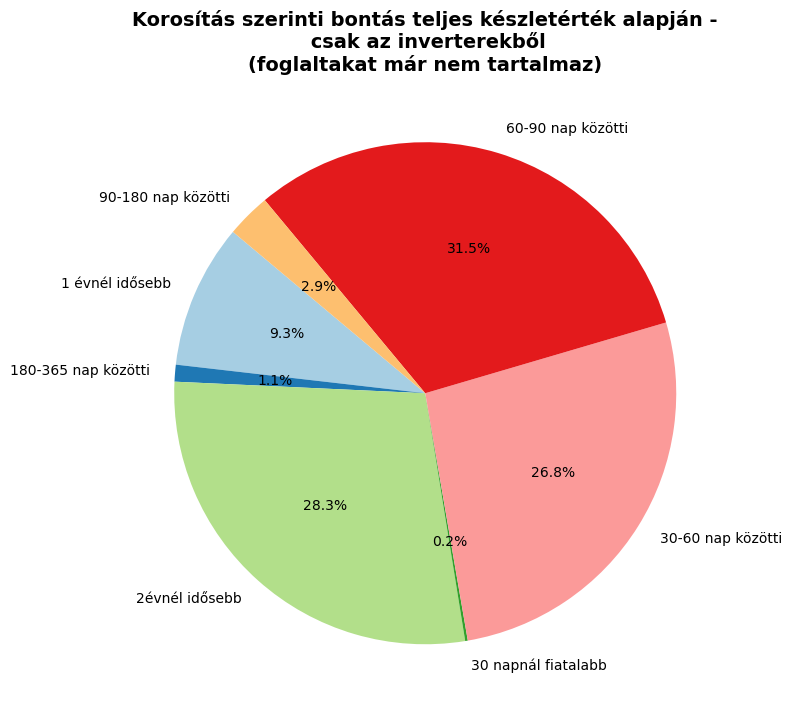

In [1573]:
# az inverterek korosítás szerint összegezve kördiagrammon

inverterek_korositas_szerint = inverterek.pivot_table(values='Teljes készletérték', index='Korosítás', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    inverterek_korositas_szerint['Teljes készletérték'],
    labels=inverterek_korositas_szerint.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Korosítás szerinti bontás teljes készletérték alapján -\n csak az inverterekből\n(foglaltakat már nem tartalmaz)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('inverterek_korositas_szerint_ertek_alapjan.png')
plt.show()

inverterek_korositas_szerint.to_excel('inverterek_korositas_szerint_ertek_alapjan.xlsx')

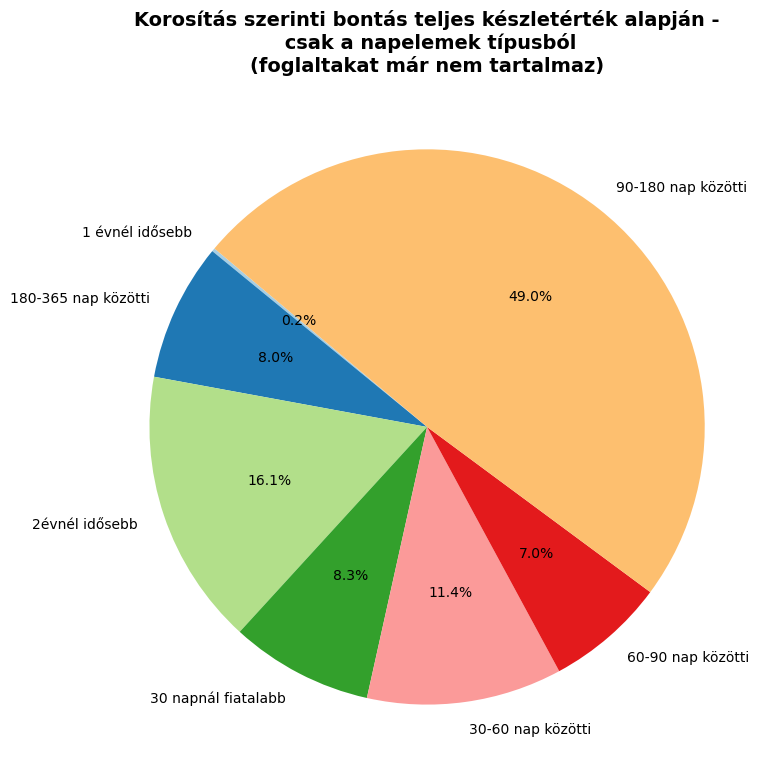

In [ ]:
#a napelemek típusból korosítás szerint összegezve kördiagrammon

napelemek_korositas_szerint = napelemek.pivot_table(values='Teljes készletérték', index='Korosítás', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    napelemek_korositas_szerint['Teljes készletérték'],
    labels=napelemek_korositas_szerint.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Korosítás szerinti bontás teljes készletérték alapján -\n csak a napelemek típusból\n(foglaltakat már nem tartalmaz)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('napelemek_korositas_szerint_ertek_alapjan.png')

plt.show()

napelemek_korositas_szerint.to_excel('napelemek_korositas_szerint_ertek_alapjan.xlsx')

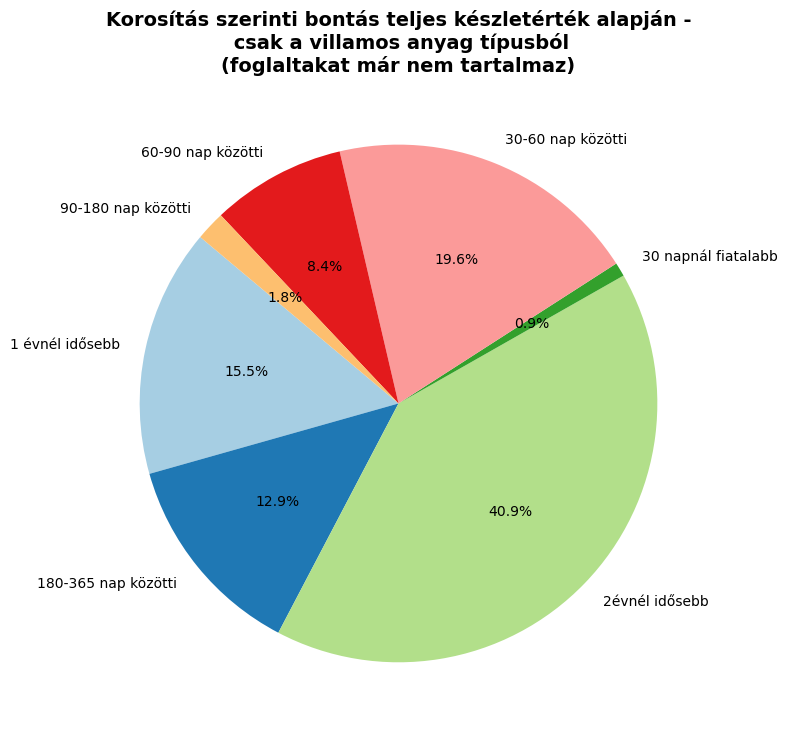

In [1575]:
#a villamos_anyag típusból korosítás szerint összegezve kördiagrammon

villamos_anyag_korositas_szerint = villamos_anyag.pivot_table(values='Teljes készletérték', index='Korosítás', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    villamos_anyag_korositas_szerint['Teljes készletérték'],
    labels=villamos_anyag_korositas_szerint.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Korosítás szerinti bontás teljes készletérték alapján -\n csak a villamos anyag típusból\n(foglaltakat már nem tartalmaz)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('villamos_anyag_korositas_szerint_ertek_alapjan.png')
plt.show()

villamos_anyag_korositas_szerint.to_excel('villamos_anyag_korositas_szerint_ertek_alapjan.xlsx')

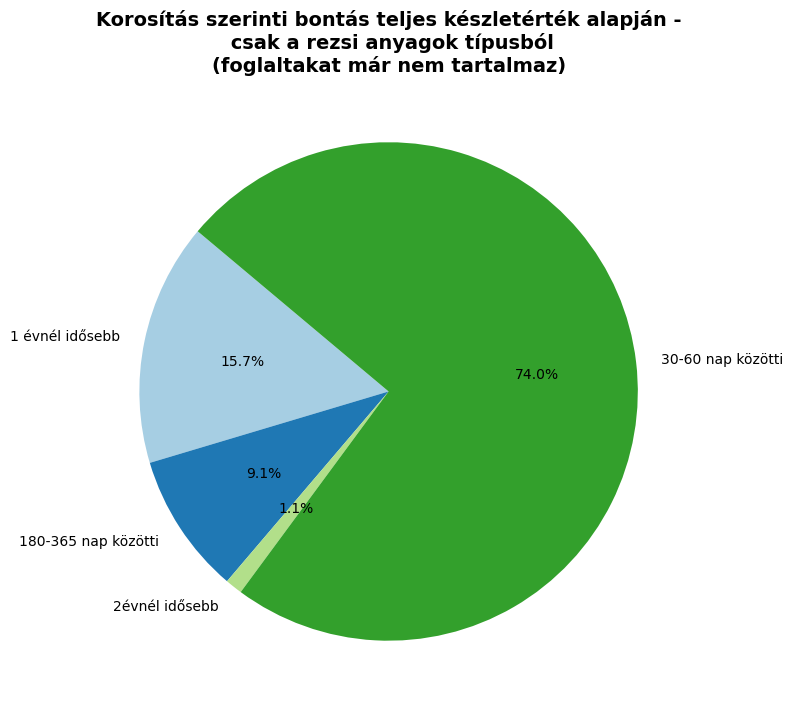

In [1576]:
#a rezsianyagok típusból korosítás szerint összegezve kördiagrammon

rezsi_anyagok_korositas_szerint = rezsi_anyagok.pivot_table(values='Teljes készletérték', index='Korosítás', aggfunc='sum')

plt.figure(figsize=(8, 8))
plt.pie(
    rezsi_anyagok_korositas_szerint['Teljes készletérték'],
    labels=rezsi_anyagok_korositas_szerint.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Korosítás szerinti bontás teljes készletérték alapján -\n csak a rezsi anyagok típusból\n(foglaltakat már nem tartalmaz)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('rezsianyagok_korositas_szerint_ertek_alapjan.png')
plt.show()

rezsi_anyagok_korositas_szerint.to_excel('rezsianyagok_korositas_szerint_ertek_alapjan.xlsx')

A 'clamp' szót tartalmazó sorok összesített készletértéke: 24803864.39
Ennyi sorból jött ez össze:  42


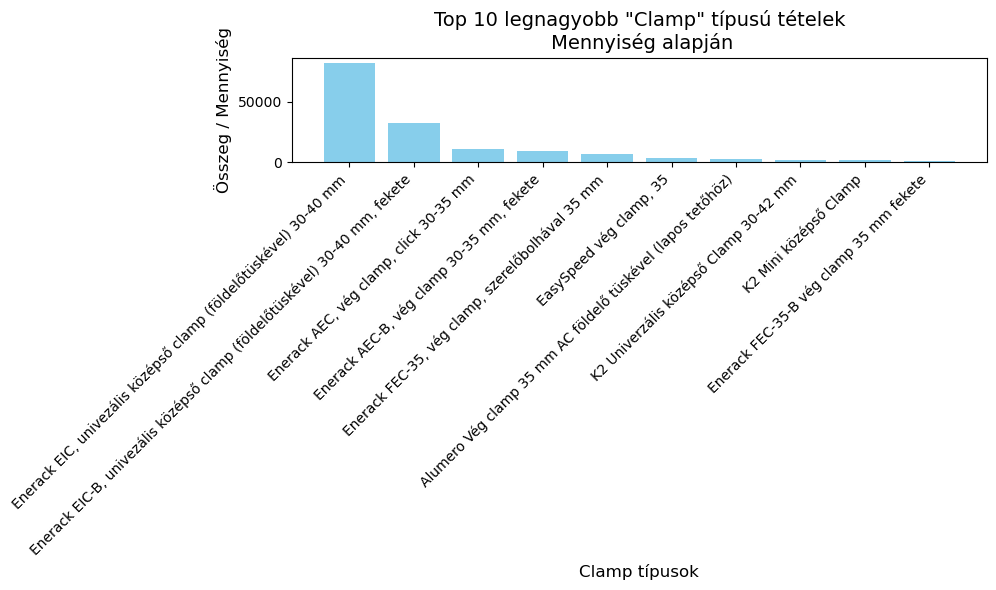

In [1577]:

#Sok a clamp elnevezésű

clamps = df[df['Unnamed: 1'].str.contains("clamp", case=False, na=False)].copy()

total_value = clamps['Teljes készletérték'].sum()

print(f"A 'clamp' szót tartalmazó sorok összesített készletértéke: {total_value}")
print("Ennyi sorból jött ez össze: ", len(clamps))

clamps_by_names = clamps['Unnamed: 1'].value_counts()
clamps_by_names_sorted = clamps.groupby('Unnamed: 1').agg({'Összeg / Mennyiség': 'sum'}).sort_values(by='Összeg / Mennyiség', ascending=False).head(10)
clamps_by_names_sorted

plt.figure(figsize=(10, 6))
plt.bar(clamps_by_names_sorted.index, clamps_by_names_sorted['Összeg / Mennyiség'], color='skyblue')
plt.xlabel('Clamp típusok', fontsize=12)
plt.ylabel('Összeg / Mennyiség', fontsize=12)
plt.title('Top 10 legnagyobb "Clamp" típusú tételek\n Mennyiség alapján', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top10clamps_mennyiseg_alapjan.png')
plt.show()


clamps.to_excel('clamps.xlsx')
clamps_by_names_sorted.to_excel('top10clamps_mennyiseg_alapjan.xlsx')

In [1578]:
# Mennyi a clamp teljes készletértéke?

clamps_value = clamps['Teljes készletérték'].sum()
clamps_value

24803864.39

In [ ]:
# clamp korosítás szerint rendezve

clamps_sorted = clamps.sort_values(by='Korosítás', ascending=True)

clamps_grouped = clamps_sorted.groupby('Korosítás')['Összeg / Mennyiség'].sum()

print(clamps_grouped)
clamps_grouped.to_excel('clamps_korositas_szerint.xlsx')



Korosítás
1 évnél idősebb        5,488.00
180-365 nap közötti   93,199.00
2évnél idősebb        16,047.00
30 napnál fiatalabb      363.00
30-60 nap közötti        -26.00
90-180 nap közötti    41,379.00
Name: Összeg / Mennyiség, dtype: float64


In [1580]:
# Van két évnél fiatalabb clamp? ---- DE LENT MEG AZ ELLENTÉTJÉT MUTATJA

has_not_older_than_2_years = (clamps['Korosítás'] != '2évnél idősebb').any()

print("Van olyan clamp, ami két évnél fiatalabb? ",has_not_older_than_2_years)

Van olyan clamp, ami két évnél fiatalabb?  True


In [1581]:
# Csökkenő sorrendbe állítom először az átlagár, majd a szabad készlet szerint

df_selected = df[['Unnamed: 1', 'Összeg / Mennyiség', 'Típus', 'Szabad készlet', 'Mérlegelt átlagár', 'Korosítás']]

legdrágább_legtöbb_szabad_keszlet = df_selected.sort_values(by=['Mérlegelt átlagár', 'Szabad készlet'], ascending=[False, False])

top_5_legdrágább_legtöbb = legdrágább_legtöbb_szabad_keszlet.head(10)

print(top_5_legdrágább_legtöbb.to_string())

top_5_legdrágább_legtöbb.to_excel('atlagar_mennyiseg_szerint_csokkeno.xlsx')





                                                      Unnamed: 1  Összeg / Mennyiség           Típus  Szabad készlet  Mérlegelt átlagár            Korosítás
57                           Fronius TAURO ECO 100-3-D [3F] [EU]                1.00        Inverter            1.00       2,200,000.00    30-60 nap közötti
1053                                         Egyedi [AC] elosztó                0.00  Villamos anyag            0.00       1,875,363.06  30 napnál fiatalabb
1054  TM Mezőgép hardver (készre szerelt szekrény és tartozékai)                0.00  Villamos anyag            0.00       1,413,493.00  30 napnál fiatalabb
85                           Huawei SUN2000-100KTL-M2 [3F ] [EU]                1.00        Inverter            1.00       1,409,379.87    30-60 nap közötti
107                                 Huawei SUN2000-60KTL-M0 [EU]                1.00        Inverter            1.00       1,013,153.95       2évnél idősebb
1052                               Sofar HYD 20KTL-3PH [3F

In [ ]:
# Csoportosítunk és összegezzük a 'Teljes készletérték' oszlopot
kor_es_ar_szerint_tablazat = df.groupby('Korosítás')['Teljes készletérték'].sum().reset_index()

kor_es_ar_szerint_tablazat['Teljes készletérték'] = kor_es_ar_szerint_tablazat['Teljes készletérték'].apply(lambda x: '{:,.0f}'.format(x))


print("Új táblázat a 'kor_es_ar_szerint':")
print(kor_es_ar_szerint_tablazat)

kor_es_ar_szerint_tablazat.to_excel('kor_es_ar_szerint_osszegezve.xlsx')

Új táblázat a 'kor_es_ar_szerint':
             Korosítás Teljes készletérték
0      1 évnél idősebb          60,030,014
1  180-365 nap közötti          68,250,451
2       2évnél idősebb         199,512,909
3  30 napnál fiatalabb           6,421,129
4    30-60 nap közötti         125,659,225
5    60-90 nap közötti         126,992,554
6   90-180 nap közötti          73,477,913


In [1583]:
# Csináltam egy új táblázatot, csak a 2 évnél idősebbekről

df_2evnel_idosebb = df[df['Korosítás'] == '2évnél idősebb']

df_2evnel_idosebb.to_excel('minden_ami_2evnel_idosebb.xlsx')


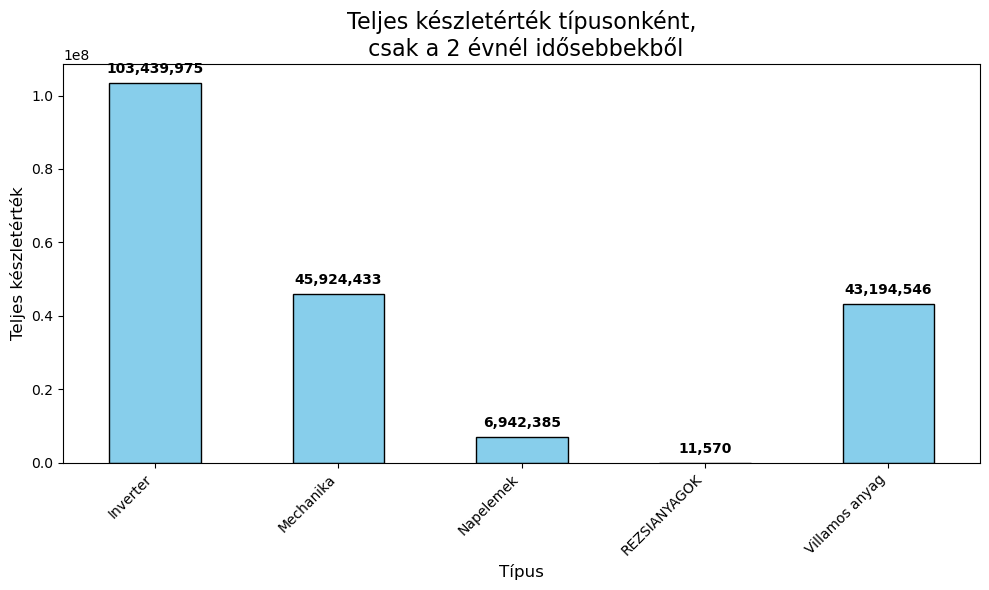

In [ ]:
# Csoportosítunk 'Típus' alapján, és összeadjuk az 'Teljes készletérték' oszlop értékeit - CSAK A 2 ÉVNÉL IDŐSEBBEKBŐL

tipus_ossz_mennyiseg = df_2evnel_idosebb.groupby('Típus')['Teljes készletérték'].sum()


plt.figure(figsize=(10, 6)) 
ax = tipus_ossz_mennyiseg.plot(kind='bar', color='skyblue', edgecolor='black') 


for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Teljes készletérték típusonként,\n csak a 2 évnél idősebbekből', fontsize=16)

plt.xlabel('Típus', fontsize=12)
plt.ylabel('Teljes készletérték', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('ket_evnel_regebbi_tipus_alapjan_teljes_keszletertek.png')
plt.show()

tipus_ossz_mennyiseg.to_excel('ket_evnel_regebbi_tipus_alapjan_teljes_keszletertek.xlsx')


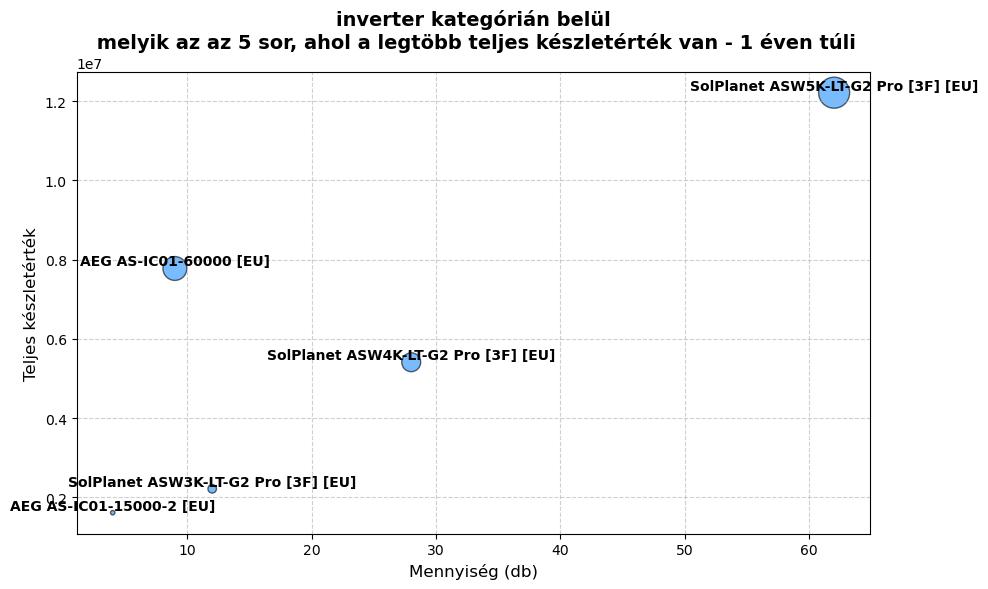

In [ ]:
# inverter kategórián belül melyik az az 5 sor, ahol a legtöbb teljes készletérték van - 1 éven túli

inverterek_sorted = inverterek[inverterek['Korosítás'].isin(['2 évnél idősebb', '1 évnél idősebb'])]
inverterek_sorted = inverterek_sorted.sort_values(by='Teljes készletérték', ascending=False).head(5)
inverterek_sorted


inverterek_sorted.to_excel('egy_even_tuli_inverterek_keszletertek_alapjan_csokkeno.xlsx')

min_size = 10
max_size = 500

sizes = np.interp(inverterek_sorted['Teljes készletérték'], 
                  (inverterek_sorted['Teljes készletérték'].min(), inverterek_sorted['Teljes készletérték'].max()), 
                  (min_size, max_size))

plt.figure(figsize=(10, 6))

plt.scatter(
    inverterek_sorted['Összeg / Mennyiség'],
    inverterek_sorted['Teljes készletérték'],
    s=sizes,
    alpha=0.6,
    color='dodgerblue',
    edgecolors='black'
)

for i, txt in enumerate(inverterek_sorted['Unnamed: 1']):
    plt.annotate(txt, 
                 (inverterek_sorted['Összeg / Mennyiség'].iloc[i], inverterek_sorted['Teljes készletérték'].iloc[i]), 
                 fontsize=10, ha='center', va='bottom', fontweight='bold')


plt.xlabel("Mennyiség (db)", fontsize=12)
plt.ylabel("Teljes készletérték", fontsize=12)
plt.title("inverter kategórián belül\n melyik az az 5 sor, ahol a legtöbb teljes készletérték van - 1 éven túli", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('egy_even_tuli_inverterek_keszletertek_alapjan_csokkeno.png')
plt.show()




In [1586]:
# a két évnél régebbi inverterek, teljes készletérték alapján csökkenő sorrendben

ket_evnel_idosebb_inverterek = df_2evnel_idosebb[df_2evnel_idosebb['Típus'] == 'Inverter']
ket_evnel_idosebb_inverterek_keszletertek_alapjan = ket_evnel_idosebb_inverterek.sort_values(by="Teljes készletérték", ascending=False)
ket_evnel_idosebb_inverterek_keszletertek_alapjan

ket_evnel_idosebb_inverterek_keszletertek_alapjan.to_excel('2evnel_regebbi_inverterek_ertek_alapjan_csokkeno.xlsx', index=False)

In [ ]:

# a két évnél idősebb inverterek mérlegelt átlagár alapján csökkenő sorrendben

print(ket_evnel_idosebb_inverterek.sort_values(by='Mérlegelt átlagár', ascending=False)['Mérlegelt átlagár'].head(10))

ket_evnel_idosebb_inverterek_sorted = ket_evnel_idosebb_inverterek.sort_values(by='Mérlegelt átlagár', ascending=False)

pd.set_option('display.float_format', '{:,.2f}'.format)
ket_evnel_idosebb_inverterek_sorted

ket_evnel_idosebb_inverterek_sorted.to_excel('2evnel_regebbi_inverterek_egysegar_alapjan_csokkeno.xlsx', index=False)



107   1,013,153.95
72      842,400.00
139     726,023.90
19      722,894.41
88      654,111.16
152     621,720.00
154     618,481.06
155     615,600.00
95      591,120.00
54      570,708.23
Name: Mérlegelt átlagár, dtype: float64


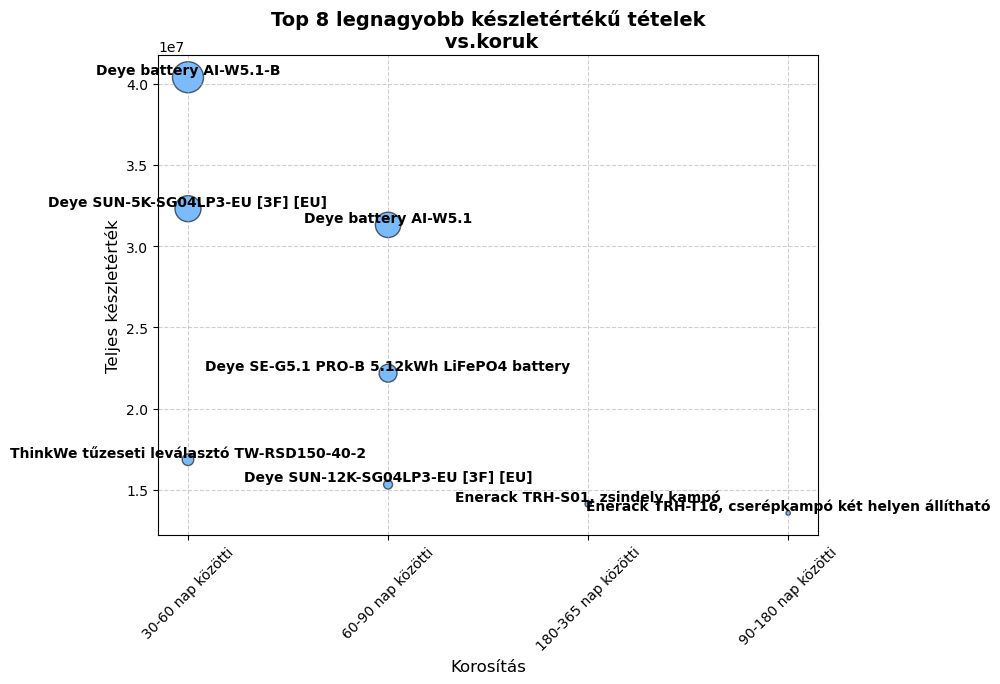

In [ ]:
# scatter diagram a készletértékről és a korosításról, ebből a top 8, nincs típusonkénti bontás


top_8 = df.sort_values(by='Teljes készletérték', ascending=False).head(8)

top_8.to_excel('keszletertekrol_es_korositasrol_top8_tipusonkent.xlsx')

min_size = 10
max_size = 500
sizes = np.interp(top_8['Teljes készletérték'], 
                  (top_8['Teljes készletérték'].min(), top_8['Teljes készletérték'].max()), 
                  (min_size, max_size))

plt.figure(figsize=(10, 6))


plt.scatter(
    top_8['Korosítás'],
    top_8['Teljes készletérték'],
    s=sizes,
    alpha=0.6,
    color='dodgerblue',
    edgecolors='black'
)


for i, txt in enumerate(top_8['Unnamed: 1']):
    plt.annotate(txt, 
                 (top_8['Korosítás'].iloc[i], top_8['Teljes készletérték'].iloc[i]), 
                 fontsize=10, ha='center', va='bottom', fontweight='bold')


plt.xlabel("Korosítás", fontsize=12)
plt.ylabel("Teljes készletérték", fontsize=12)
plt.title("Top 8 legnagyobb készletértékű tételek\n vs.koruk", fontsize=14, fontweight='bold')


plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.savefig('keszletertekrol_es_korositasrol_top8_tipusonkent.png')
plt.show()



In [1589]:
# a két évnél idősebb mechanika típusúak,teljes készletérték alapján csökkenő sorrendben

ket_evnel_idosebb_mechanika = df_2evnel_idosebb[df_2evnel_idosebb['Típus'] == 'Mechanika']
ket_evnel_idosebb_mechanika_sorted = ket_evnel_idosebb_mechanika.sort_values(by='Teljes készletérték', ascending=False).head(10)
pd.set_option('display.float_format', '{:,.2f}'.format)
ket_evnel_idosebb_mechanika_sorted

ket_evnel_idosebb_mechanika_sorted.to_excel('ketevesnel_idosebb_mechanika_ertek_alapjan_csokkeno.xlsx', index=False)

In [1590]:
# napelemekből a 100 db fölötti tételek, 1 éven túliból 

napelemek_sorted = napelemek[napelemek['Korosítás'].isin(['2évnél idősebb', '1 évnél idősebb'])].head(10)
napelemek_sorted

napelemek_sorted.to_excel('napelemek_1even_tuli_legtobb_darab.xlsx', index=False)

In [1591]:
# 2 évnél idősebb villamos anyag, teljes készletérték szerint csökkenő sorrendben

ket_evnel_idosebb_villamos_anyag = df_2evnel_idosebb[df_2evnel_idosebb['Típus'] == 'Villamos anyag']
ket_evnel_idosebb_villamos_anyag_sorted = ket_evnel_idosebb_villamos_anyag.sort_values(by='Teljes készletérték', ascending=False).head(10)
pd.set_option('display.float_format', '{:,.2f}'.format)
ket_evnel_idosebb_villamos_anyag_sorted

ket_evnel_idosebb_villamos_anyag_sorted.to_excel('2evnel_regebbi_villamos_ertek_alapjan_csokkeno.xlsx', index=False)

In [1592]:
#top 10 legnagyobb készletértékű sor a villamos anyagból - 1 éven túliról

egyevesnel_idosebb_villamos_anyag = villamos_anyag[villamos_anyag['Korosítás'].isin(['2évnél idősebb', '1 évnél idősebb'])]
legtobb_keszletertek_egyeventuli_villamosbol_top_10 = egyevesnel_idosebb_villamos_anyag.sort_values(by='Teljes készletérték', ascending=False).head(10)
legtobb_keszletertek_egyeventuli_villamosbol_top_10

legtobb_keszletertek_egyeventuli_villamosbol_top_10.to_excel('1even_tuli_villamos_top10_keszletertek.xlsx', index=False)